In [1]:
import os,csv
import numpy as np
from intervaltree import IntervalTree
from scipy.io import wavfile
from scipy.signal import resample
import matplotlib.pyplot as plt
from IPython import display

# Loading the data

In [30]:
dataroot = 'data/whois/train_data_09222019/'
labeltrain = os.path.join(dataroot,'train.tsv')
labeldev = os.path.join(dataroot,'dev.tsv')

data = dict()
labels = dict()

fs = 44100.
for labelfile in [labeltrain,labeldev]:
    with open(labelfile) as f:
        for i,(wav,start,dur,loc,date,master) in enumerate(csv.reader(f, delimiter='\t')):
            if i == 0: continue
            if wav not in data.keys():
                xfs, x = wavfile.read(os.path.join(dataroot,'wav',wav))
                xp = np.arange((fs/xfs)*len(x),dtype=np.float32)
                x = np.interp((xfs/fs)*xp,np.arange(len(x),dtype=np.float32),x).astype(np.float32)
                data[wav] = x
                labels[wav] = IntervalTree()
            
            if float(dur) < 0.1:
                print('Small duration label in {} (dur {}); ignoring'.format(wav,dur))
                continue
            
            labels[wav][int(float(start)*fs):int((float(start)+float(dur))*fs)] = 1

Small duration label in 9750400O.wav (dur 0.0); ignoring
Small duration label in 9750401G.wav (dur 0.0); ignoring
Small duration label in 9750402R.wav (dur 0.0); ignoring
Small duration label in 9761900E.wav (dur 0.0); ignoring
Small duration label in 9761900O.wav (dur 0.0); ignoring
Small duration label in 9761900U.wav (dur 0.0); ignoring
Small duration label in 9769201O.wav (dur 0.0); ignoring
Small duration label in 9769202C.wav (dur 0.0); ignoring
Small duration label in 9774300J.wav (dur 0.0); ignoring
Small duration label in 64017_0000.wav (dur 0.01); ignoring
Small duration label in 65009_0006.wav (dur 0.01); ignoring
Small duration label in 65009_000c.wav (dur 0.01); ignoring
Small duration label in 65009_000d.wav (dur 0.01); ignoring
Small duration label in 65009_0011.wav (dur 0.01); ignoring
Small duration label in 65009_0013.wav (dur 0.01); ignoring
Small duration label in 65009_0016.wav (dur 0.01); ignoring
Small duration label in 65009_001a.wav (dur 0.01); ignoring
Small d

In [38]:
randitem = list(data.keys())[np.random.randint(len(data.keys()))]
print(randitem)

9230403E.wav


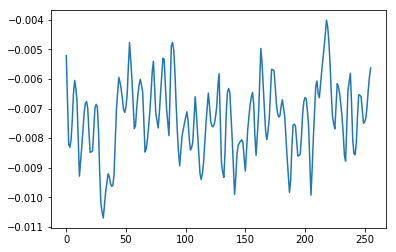

In [39]:
plt.plot(data[randitem][0:256])

9775400N.wav
0 58511 58511 1.326780045351474


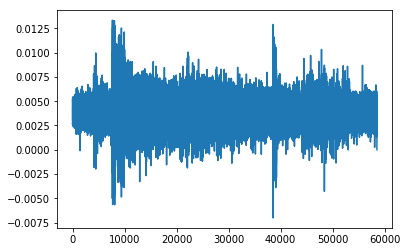

In [47]:
randitem = list(data.keys())[np.random.randint(len(data.keys()))]
start,end,label = list(labels[randitem])[np.random.randint(len(labels[randitem]))]

print(randitem)
print(start,end,end-start,(end-start)/float(fs))
clip = data[randitem][start:end]
plt.plot(clip)
display.Audio(clip,rate=fs)

# Using a dataloader

In [2]:
import lib.dataset as dataset
from lib.acoustic_model import AcousticModel
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [6]:
whois_set = dataset.WhoisDataset(root='data', train=True, window=4096, stride=8192)
whois_loader = DataLoader(dataset=whois_set,batch_size=1000,**dataset.worker_config)

Loaded dataset with 106129 datapoints


In [7]:
class Model(AcousticModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def define_graph(self, debug=False):
        self.k = 512
        self.d = 1024
        self.stride = 512
        
        self.wsin, self.wcos = self.create_filters(self.d,self.k)
    
    def forward(self, x, y):
        zx = F.conv1d(x[:,None,:], self.wsin, stride=self.stride).pow(2) \
           + F.conv1d(x[:,None,:], self.wcos, stride=self.stride).pow(2)
        return zx

In [8]:
model = Model('checkpoints/_dataset')
xmin = smin = 10000
xmax = smax = 0
xsum = ssum = 0

for i, (x,y) in enumerate(whois_loader):
    xmin = min(torch.min(x).cpu().numpy(),xmin)
    xmax = max(torch.max(x).cpu().numpy(),xmax)
    xsum += torch.mean(x).cpu().numpy()
    
    s = torch.log(1+model(x.cuda(),y.cuda()))
    
    smin = min(torch.min(s).cpu().numpy(),smin)
    smax = max(torch.max(s).cpu().numpy(),smax)
    ssum += torch.mean(s).cpu().numpy()

Initialized graph with 0 parameters


In [10]:
print(xmin,xmax,xsum/len(whois_loader))
print(smin,smax,ssum/len(whois_loader))

-0.24873094 0.22419697 -0.0007415376181450002
0.0 6.4372516 0.8235749181742981
